Bài toán 1: Đề xuất người dùng với Content-based filtering

### Bước 1: Business Understanding

Vấn đề hiện tại:
Chưa có hệ thống Recommendation System để hỗ trợ người dùng chọn nơi lưu trú phù hợp trên Agoda

Mục tiêu:
Xây dựng hệ thống đề xuất để hỗ trợ người dùng nhanh chóng chọn được nơi lưu trú phù hợp trên Agoda bằng phương pháp Content-based filtering.

※Content-based filtering: Mô hình này sẽ dựa trên thông tin và đặc điểm của các nơi lưu trú (như dịch vụ, tiện nghi, vị trí, loại phòng) để đề xuất những nơi tương tự mà người dùng có thể quan tâm dựa trên lịch sử tìm kiếm và đánh giá của họ.

### Bước 2: Data Understanding-Tiền xử lý dữ liệu

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re

In [15]:
## Đọc dữ liệu từ các file CSV
hotel_info = pd.read_csv('hotel_info.csv')

In [16]:
hotel_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

※Tổng dữ liệu có 740 dòng.
các cột đánh giá có giá trị null
Cần chuyển đổi kiểu dữ liệu các cột Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality từ string-> float
Tạo thêm cột đặc trưng

In [17]:
hotel_info.head()

,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,4,1_4,Panorama Star Beach Nha Trang,5 sao trên 5,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...","8,8","9,6","8,9","8,9","8,7","9,0",NaN,814,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,5,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,4 sao trên 5,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,4","8,5","8,7","8,5","8,3","8,6","8,7",294,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [18]:
hotel_info = hotel_info.drop(columns=['num'])

In [19]:
hotel_info.isnull().sum()

Hotel_ID                      0
Hotel_Name                    0
Hotel_Rank                    0
Hotel_Address                 0
Total_Score                   0
Location                    327
Cleanliness                 328
Service                     367
Facilities                  370
Value_for_money             330
Comfort_and_room_quality    689
comments_count                0
Hotel_Description             1
dtype: int64

Tách 2 file: 
1.dữ liệu tiếng việt 
2.dữ liệu tiếng anh
・Dịch cột description -> tiếng việt

file tổng = file 1+ file 2
※chấp nhận bỏ ngôn khác 2 ngôn ngữ trên (tiếng hàn :1 dòng)

In [20]:
import pandas as pd
from langdetect import detect

# Function to detect Vietnamese
def is_vietnamese(text):
    try:
        if detect(text) == 'vi':
            return True
        else:
            return False
    except:
        return False

In [21]:
hotel_info_vi= hotel_info[hotel_info['Hotel_Description'].apply(is_vietnamese)]

In [22]:
hotel_info_vi.shape

(586, 13)

In [23]:
# Function to detect english
def is_english(text):
    try:
        if detect(text) == 'en':
            return True
        else:
            return False
    except:
        return False

In [24]:
hotel_info_nonviet = hotel_info[hotel_info['Hotel_Description'].apply(is_english)]

In [25]:
hotel_info_nonviet.shape

(151, 13)

In [26]:
hotel_info_nonviet.head()

,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
56,2_27,"Căn hộ 72 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",5 sao trên 5,"Vĩnh Phước, Nha Trang, Việt Nam","7,6","8,0","6,0",NaN,NaN,"8,0",NaN,0,"This apartment is Ocean view, 2 bedroom. You c..."
117,5_21,"Chung cư 72 m² 2 phòng ngủ, 2 phòng tắm riêng ...",5 sao trên 5,"Vĩnh Phước, Nha Trang, Việt Nam","8,9","9,2","8,4","9,6","8,0","9,2",NaN,1,• STUNNING VIEWS: Guests will be able to see M...
140,6_22,"Nhà riêng 60 m² 6 phòng ngủ, 1 phòng tắm riêng...",3.5 sao trên 5,"Vĩnh Ngọc, Nha Trang, Việt Nam","2,0","2,0","2,0",NaN,NaN,"2,0",NaN,0,"My's Dung Motel - Apartment, we welcome you to..."
150,11_30,"Căn hộ 42 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...",5 sao trên 5,"Vĩnh Hải, Nha Trang, Việt Nam","8,4","10,0","8,8","7,6","9,2","9,6",NaN,2,My new build apartment located in Nha Trang ci...
156,12_15,"Căn hộ 774 m² 2 phòng ngủ, 2 phòng tắm riêng ở...",5 sao trên 5,"Vĩnh Phước, Nha Trang, Việt Nam",No information,NaN,NaN,NaN,NaN,NaN,NaN,0,"The apartment is spacious and modern, featurin..."


In [27]:
from googletrans import Translator
from langdetect import detect

# Function to translate English text to Vietnamese
def translate_to_vietnamese(text):
    try:
        translator = Translator()
        translation = translator.translate(text, src='en', dest='vi')
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text  # Return original text if translation fails

In [28]:
hotel_info_nonviet['Hotel_Description'] = hotel_info_nonviet['Hotel_Description'].apply(translate_to_vietnamese)

Translation error: the JSON object must be str, bytes or bytearray, not NoneType
Translation error: the JSON object must be str, bytes or bytearray, not NoneType


C:\Users\81707\AppData\Local\Temp\ipykernel_18256\1522681454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_info_nonviet['Hotel_Description'] = hotel_info_nonviet['Hotel_Description'].apply(translate_to_vietnamese)


In [29]:
hotel_info_nonviet.head()

,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
56,2_27,"Căn hộ 72 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",5 sao trên 5,"Vĩnh Phước, Nha Trang, Việt Nam","7,6","8,0","6,0",NaN,NaN,"8,0",NaN,0,"Căn hộ này là Ocean View, 2 phòng ngủ.Bạn có t..."
117,5_21,"Chung cư 72 m² 2 phòng ngủ, 2 phòng tắm riêng ...",5 sao trên 5,"Vĩnh Phước, Nha Trang, Việt Nam","8,9","9,2","8,4","9,6","8,0","9,2",NaN,1,• Khung cảnh tuyệt đẹp: Khách sẽ có thể nhìn t...
140,6_22,"Nhà riêng 60 m² 6 phòng ngủ, 1 phòng tắm riêng...",3.5 sao trên 5,"Vĩnh Ngọc, Nha Trang, Việt Nam","2,0","2,0","2,0",NaN,NaN,"2,0",NaN,0,"Dung Motel của tôi - Căn hộ, chúng tôi chào đó..."
150,11_30,"Căn hộ 42 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...",5 sao trên 5,"Vĩnh Hải, Nha Trang, Việt Nam","8,4","10,0","8,8","7,6","9,2","9,6",NaN,2,Căn hộ xây dựng mới của tôi nằm ở Trung tâm th...
156,12_15,"Căn hộ 774 m² 2 phòng ngủ, 2 phòng tắm riêng ở...",5 sao trên 5,"Vĩnh Phước, Nha Trang, Việt Nam",No information,NaN,NaN,NaN,NaN,NaN,NaN,0,"Căn hộ rộng rãi và hiện đại, có 2 phòng ngủ th..."


In [30]:
hotel_info_merge=pd.concat([hotel_info_vi,hotel_info_nonviet])

In [31]:
hotel_info_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 737 entries, 0 to 709
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Hotel_ID                  737 non-null    object
 1   Hotel_Name                737 non-null    object
 2   Hotel_Rank                737 non-null    object
 3   Hotel_Address             737 non-null    object
 4   Total_Score               737 non-null    object
 5   Location                  413 non-null    object
 6   Cleanliness               412 non-null    object
 7   Service                   373 non-null    object
 8   Facilities                370 non-null    object
 9   Value_for_money           410 non-null    object
 10  Comfort_and_room_quality  51 non-null     object
 11  comments_count            737 non-null    int64 
 12  Hotel_Description         737 non-null    object
dtypes: int64(1), object(12)
memory usage: 80.6+ KB


In [32]:
hotel_info_merge.to_csv('hotel_info_merge.csv',index=False,encoding='utf-8')

In [33]:
# Kiểm tra tỷ lệ phần trăm giá trị thiếu trong mỗi cột
missing_per = hotel_info_merge.isnull().sum() / len(hotel_info) * 100
missing_per

Hotel_ID                     0.000000
Hotel_Name                   0.000000
Hotel_Rank                   0.000000
Hotel_Address                0.000000
Total_Score                  0.000000
Location                    43.783784
Cleanliness                 43.918919
Service                     49.189189
Facilities                  49.594595
Value_for_money             44.189189
Comfort_and_room_quality    92.702703
comments_count               0.000000
Hotel_Description            0.000000
dtype: float64

Các cột đánh giá:dữ liệu null chiếm gần 1/2 tổng dữ liệu,giữ lại dùng làm nội dung cho content

In [34]:
# Kiểm tra giá trị trong cột 'Hotel_Rank'
hotel_info_merge['Hotel_Rank'].unique()

array(['5 sao trên 5', '4 sao trên 5', '3.5 sao trên 5', '3 sao trên 5',
       '4.5 sao trên 5', '2.5 sao trên 5', '2 sao trên 5',
       'No information', '1 sao trên 5', '1.5 sao trên 5'], dtype=object)

In [35]:
import re

In [36]:
def extract_number(rank):
    if isinstance(rank, str) and 'sao' in rank and rank.lower() != 'no information':
        match = re.search(r'(\d+(\.\d+)?)\s*sao', rank)
        if match:
            return match.group(1).strip()  # Trả về số trước từ "sao"
    return rank  


In [37]:
hotel_info_merge['Hotel_Rank'] = hotel_info_merge['Hotel_Rank'].apply(extract_number)

In [38]:
hotel_info_merge['Hotel_Rank'].head()

0      5
1      4
2    3.5
3      5
4      4
Name: Hotel_Rank, dtype: object

In [39]:
hotel_info_merge['Hotel_Rank'].unique()

array(['5', '4', '3.5', '3', '4.5', '2.5', '2', 'No information', '1',
       '1.5'], dtype=object)

In [40]:
# Đếm số lượng của mỗi giá trị duy nhất trong cột 'Hotel_Rank'
rank_counts = hotel_info_merge['Hotel_Rank'].value_counts()
rank_counts

Hotel_Rank
No information    470
5                 123
4                  54
3                  42
3.5                16
4.5                12
2                  12
1.5                 4
2.5                 2
1                   2
Name: count, dtype: int64

Giá trị 'no information' chiếm 1/2
Kiểm tra dữ liệu thì đa phần là nhà riêng,căn hộ nhỏ
Tuy nhiên vẫn có dữ liệu đánh giá ->chuyển thành Nan

In [41]:
hotel_info_merge['Hotel_Rank'] = pd.to_numeric(hotel_info_merge['Hotel_Rank'], errors='coerce')

In [42]:
import numpy as np

In [43]:
# Chuyển giá trị 'no information' về NaN
hotel_info_merge['Hotel_Rank'] = hotel_info_merge['Hotel_Rank'].replace('No information',np.nan)

In [44]:
hotel_info_merge['Total_Score'] = hotel_info_merge['Total_Score'].replace('No information',np.nan)

In [45]:
hotel_info_merge.shape

(737, 13)

In [46]:
# hotel_info = hotel_info.dropna(subset=['Total_Score', 'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money', 'Comfort_and_room_quality'], how='all')
# hotel_info.shape

In [47]:
columns=['Total_Score', 'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money', 'Comfort_and_room_quality']

In [48]:
#Chuyển định đạng cho các cột đánh giá
for column in columns:
    # Thay thế dấu phẩy bằng dấu chấm
    hotel_info_merge[column] = hotel_info_merge[column].astype(str).str.replace(',', '.')
    # Chuyển đổi cột sang kiểu float
    hotel_info_merge[column] = pd.to_numeric(hotel_info_merge[column], errors='coerce')

In [49]:
hotel_info_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 737 entries, 0 to 709
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Hotel_ID                  737 non-null    object 
 1   Hotel_Name                737 non-null    object 
 2   Hotel_Rank                267 non-null    float64
 3   Hotel_Address             737 non-null    object 
 4   Total_Score               414 non-null    float64
 5   Location                  413 non-null    float64
 6   Cleanliness               412 non-null    float64
 7   Service                   373 non-null    float64
 8   Facilities                370 non-null    float64
 9   Value_for_money           410 non-null    float64
 10  Comfort_and_room_quality  51 non-null     float64
 11  comments_count            737 non-null    int64  
 12  Hotel_Description         737 non-null    object 
dtypes: float64(8), int64(1), object(4)
memory usage: 80.6+ KB


In [50]:
# Kiểm tra số lượng giá trị NaN trong từng cột
nan_counts = hotel_info_merge.isna().sum()
nan_counts

Hotel_ID                      0
Hotel_Name                    0
Hotel_Rank                  470
Hotel_Address                 0
Total_Score                 323
Location                    324
Cleanliness                 325
Service                     364
Facilities                  367
Value_for_money             327
Comfort_and_room_quality    686
comments_count                0
Hotel_Description             0
dtype: int64

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
#Tính toán ma trận tương quan giữa các biến đánh giá với hotel rank
corr_matrix = hotel_info_merge[['Hotel_Rank', 'Total_Score', 'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money', 'Comfort_and_room_quality']].corr()

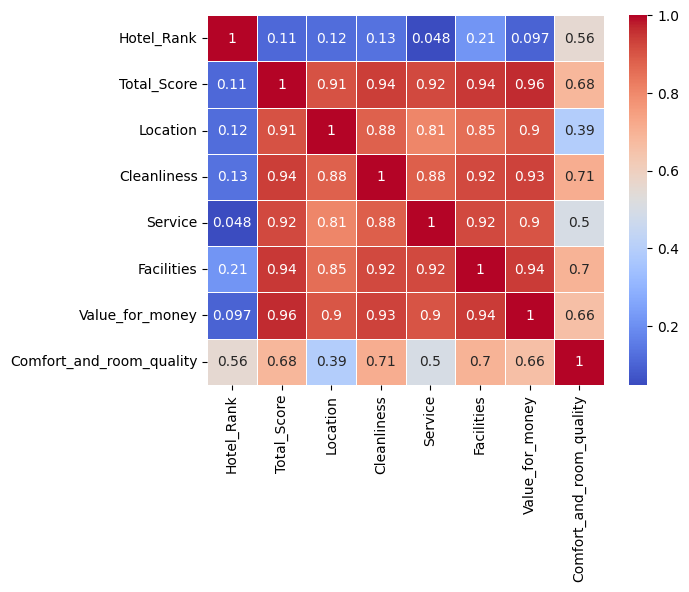

In [53]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

・Hotel_Rank:chỉ số tương quan của các biến đánh giá với hotel rank thấp,chỉ có biến 'service' và 'comfort and room quality' có  mối liên hệ dương, nhưng không mạnh.
・Total_Score:có tương quan dương mạnh với các biến 'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money', 'Comfort_and_room_quality'
・Sử dụng cột 'Cleanliness', 'Service', 'Facilities' để bổ sung cho content

In [54]:
# Xem phân phối giá trị của các cột 'Cleanliness', 'Service', 'Facilities'
hotel_info_merge[['Cleanliness', 'Service', 'Facilities']].describe()

,Cleanliness,Service,Facilities
count,412.000000,373.000000,370.000000
mean,8.121845,8.295442,7.903514
std,1.914246,1.741000,1.697763
min,2.000000,2.000000,2.000000
25%,7.800000,8.000000,7.425000
50%,8.700000,8.800000,8.250000
75%,9.200000,9.200000,8.900000
max,10.000000,10.000000,10.000000


In [55]:
# Điền giá trị thiếu bằng trung bình hoặc trung vị
hotel_info_merge['Cleanliness'].fillna(hotel_info_merge['Cleanliness'].median(), inplace=True)
hotel_info_merge['Service'].fillna(hotel_info_merge['Service'].median(), inplace=True)
hotel_info_merge['Facilities'].fillna(hotel_info_merge['Facilities'].median(), inplace=True)

C:\Users\81707\AppData\Local\Temp\ipykernel_18256\1482387830.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hotel_info_merge['Cleanliness'].fillna(hotel_info_merge['Cleanliness'].median(), inplace=True)
C:\Users\81707\AppData\Local\Temp\ipykernel_18256\1482387830.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [56]:
nan_counts_1 = hotel_info_merge.isna().sum()
nan_counts_1

Hotel_ID                      0
Hotel_Name                    0
Hotel_Rank                  470
Hotel_Address                 0
Total_Score                 323
Location                    324
Cleanliness                   0
Service                       0
Facilities                    0
Value_for_money             327
Comfort_and_room_quality    686
comments_count                0
Hotel_Description             0
dtype: int64

In [57]:
hotel_info_merge[['Cleanliness', 'Service', 'Facilities']].describe()

,Cleanliness,Service,Facilities
count,737.000000,737.000000,737.000000
mean,8.376798,8.544640,8.076052
std,1.459030,1.263224,1.214566
min,2.000000,2.000000,2.000000
25%,8.500000,8.800000,8.200000
50%,8.700000,8.800000,8.250000
75%,8.800000,8.800000,8.300000
max,10.000000,10.000000,10.000000


Ý tưởng:dựa trên 3 tiếu chí đánh giá 'Cleanliness', 'Service', 'Facilities' chuyển điểm đánh giá thành nội dung văn bản ví dụ:Phòng sạch sẽ,Dịch vụ tốt,Tiện nghi tuyệt vời,... tuy nhiên chưa tìm được hướng phát triển ý tưởng,tạm thời bảo lưu idea này.

In [58]:
hotel_info_merge.head()

,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5.0,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.8,9.4,8.9,8.9,8.7,8.7,8.3,1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,1_2,ALPHA BIRD NHA TRANG,4.0,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...",7.7,7.8,7.6,8.1,7.5,8.1,NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,1_3,Khách sạn Aaron (Aaron Hotel),3.5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...",8.5,8.9,8.7,8.8,8.1,8.5,NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,1_4,Panorama Star Beach Nha Trang,5.0,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...",8.8,9.6,8.9,8.9,8.7,9.0,NaN,814,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,4.0,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.4,8.5,8.7,8.5,8.3,8.6,8.7,294,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [59]:
# Tạo một hàm để lấy tên phường
def extract_ward(address):
    # Tách địa chỉ thành danh sách các phần
    parts = address.split(', ')
    # Tìm vị trí của 'Nha Trang' từ dưới lên
    try:
        idx = parts[::-1].index('Nha Trang')
        # Tính toán chỉ số của tên phường
        ward_name = parts[-(idx + 2)].strip()  # Lấy phần trước 'Nha Trang'
        return ward_name
    except ValueError:
        return None

In [60]:
hotel_info_merge['Ward_Name'] = hotel_info_merge['Hotel_Address'].apply(extract_ward)

In [61]:
hotel_info_merge['Ward_Name'].head()

0    Lộc Thọ
1    Lộc Thọ
2    Lộc Thọ
3    Lộc Thọ
4    Lộc Thọ
Name: Ward_Name, dtype: object

In [62]:
# Lấy danh sách các giá trị duy nhất từ cột 'Ward Name'
unique_wards = hotel_info_merge['Ward_Name'].unique()
unique_wards

array(['Lộc Thọ', 'Vĩnh Hải', 'Vĩnh Phước', 'Cam Hải Đông', 'Tân Lập',
       'Vĩnh Hòa', 'Vĩnh Nguyên', 'Xương Huân', 'Vĩnh Trường',
       'Vạn Thắng', 'Dốc Lết', 'Phước Hòa', 'Hòn Tre', 'Cam Ranh',
       'Vịnh Ninh Vân', 'Ngọc Hiệp', 'Phước Long', 'Cam Đức',
       'Vĩnh Thạnh', 'Vĩnh Hiệp', 'Biển Bãi Dài', 'Vịnh Vân Phong',
       'Vĩnh Ngọc', 'Phước Hạ', 'Vĩnh Thái', 'Vạn Ninh',
       'Huyện Diên Khánh', 'Vĩnh Phương', 'Phước Hải', 'Phước Tiến'],
      dtype=object)

In [63]:
# Chuyển toàn bộ giá trị trong cột 'Ward' về dạng 'lộc_thọ'
hotel_info_merge['Ward_Name'] = hotel_info_merge['Ward_Name'].str.lower().str.replace(' ', '_')

In [64]:
unique_wards = hotel_info_merge['Ward_Name'].unique()
unique_wards

array(['lộc_thọ', 'vĩnh_hải', 'vĩnh_phước', 'cam_hải_đông', 'tân_lập',
       'vĩnh_hòa', 'vĩnh_nguyên', 'xương_huân', 'vĩnh_trường',
       'vạn_thắng', 'dốc_lết', 'phước_hòa', 'hòn_tre', 'cam_ranh',
       'vịnh_ninh_vân', 'ngọc_hiệp', 'phước_long', 'cam_đức',
       'vĩnh_thạnh', 'vĩnh_hiệp', 'biển_bãi_dài', 'vịnh_vân_phong',
       'vĩnh_ngọc', 'phước_hạ', 'vĩnh_thái', 'vạn_ninh',
       'huyện_diên_khánh', 'vĩnh_phương', 'phước_hải', 'phước_tiến'],
      dtype=object)

In [65]:
# Chuyển đổi các giá trị trong cột 'hotel_rank' thành dạng '5_sao'
hotel_info_merge['Hotel_Rank'] = hotel_info_merge['Hotel_Rank'].astype(str) + '_sao'

In [66]:
hotel_info_merge['Hotel_Rank'].head()

0    5.0_sao
1    4.0_sao
2    3.5_sao
3    5.0_sao
4    4.0_sao
Name: Hotel_Rank, dtype: object

In [67]:
#Kiểm tra dữ liệu cột "Hotel_Description" có giá trị là #NAME?, chuyển "#NAME?" -> 
hotel_info_merge[hotel_info_merge['Hotel_Description']=='#NAME?']

,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description,Ward_Name
499,40_29,"Căn hộ 40 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...",nan_sao,"02 Hung Vuong, Panorama, Lộc Thọ, Nha Trang, V...",7.2,7.5,7.1,7.1,8.25,NaN,NaN,0,#NAME?,lộc_thọ
524,39_23,"Căn hộ 50 m² 2 phòng ngủ, 1 phòng tắm riêng ở ...",nan_sao,"Lộc Thọ, Nha Trang, Việt Nam",NaN,NaN,8.7,8.8,8.25,NaN,NaN,0,#NAME?,lộc_thọ
554,39_10,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",nan_sao,"Xương Huân, Nha Trang, Việt Nam",NaN,NaN,8.7,8.8,8.25,NaN,NaN,0,#NAME?,xương_huân
602,35_7,Căn hộ ở góc hướng biển (Seaview corner apartm...,nan_sao,"Vĩnh Phước, Nha Trang, Việt Nam",NaN,NaN,8.7,8.8,8.25,NaN,NaN,0,#NAME?,vĩnh_phước


※Có 4 dòng có giá trị #NAME?

In [68]:
# Thay thế các giá trị '#NAME?' bằng chuỗi rỗng ''
hotel_info_merge['Hotel_Description'] = hotel_info_merge['Hotel_Description'].replace('#NAME?', '')

In [69]:
# Loại bỏ các giá trị rỗng cột Hotel_Description
hotel_info_merge = hotel_info_merge.dropna(subset=['Hotel_Description'])

In [70]:
hotel_info_merge.shape

(737, 14)

In [71]:
# Đếm số lượng từ trong mỗi dòng của cột 'Hotel_Description'
hotel_info_merge['Word_Count'] = hotel_info_merge['Hotel_Description'].apply(lambda x: len(x.split()))

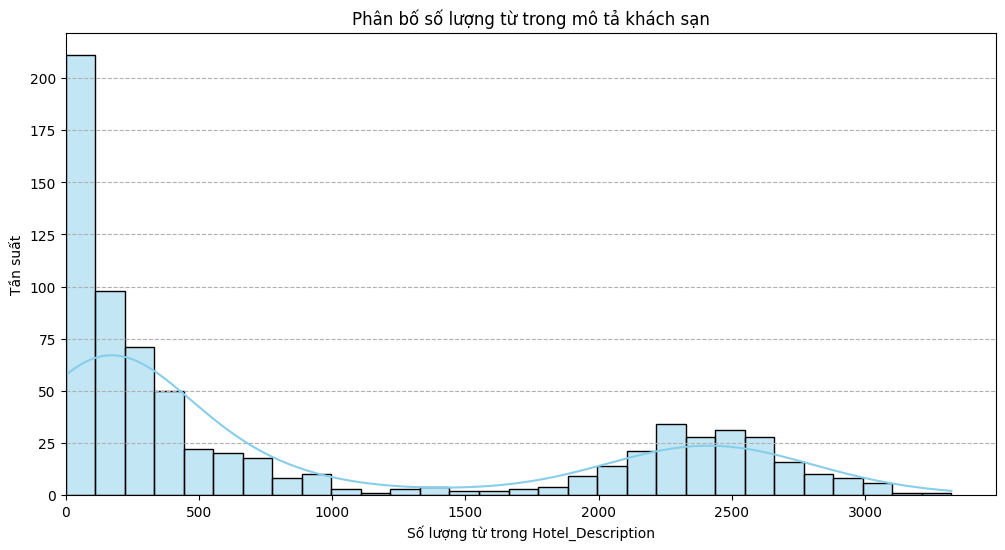

In [72]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(12, 6))
sns.histplot(hotel_info_merge['Word_Count'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Số lượng từ trong Hotel_Description')
plt.ylabel('Tần suất')
plt.title('Phân bố số lượng từ trong mô tả khách sạn')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True, axis='y', linestyle='--')
plt.show()

Dựa trên biểu đồ phân bố trên có thể thấy số lượng từ trong mỗi dòng dao động từ 400 từ trở xuống nhiều
->chọn 400 từ đầu tiên để phân tích

In [73]:
# Hàm để lấy 400 từ đầu tiên nếu số lượng từ lớn hơn 400
def get_words(text):
    words = text.split()
    if len(words) > 400:
        return ' '.join(words[:400])
    else:
        return text  # Trả về toàn bộ nội dung nếu có ít hơn hoặc bằng 400 từ


hotel_info_merge['Content'] = hotel_info_merge['Hotel_Description'].apply(get_words)

In [74]:
pd.set_option('display.max_colwidth', None)

In [75]:
hotel_info_merge['Content'].head()

0                        Khách sạn Mường Thanh Luxury Nha Trang - Nơi lưu trú tuyệt vời tại Nha Trang Khách sạn Mường Thanh Luxury Nha Trang nằm ở trung tâm thành phố Nha Trang, Việt Nam, là một khách sạn 5 sao đẳng cấp. Với vị trí thuận lợi, khách sạn này chỉ cách trung tâm thành phố 0.2 km và cách sân bay khoảng 39 phút đi xe. Khách sạn Mường Thanh Luxury Nha Trang được xây dựng vào năm 2014 và hiện có tổng cộng 458 phòng. Với số lượng phòng lớn như vậy, khách sạn này đảm bảo sẽ đáp ứng được nhu cầu lưu trú của du khách một cách thoải mái và tiện nghi. Thời gian nhận phòng tại khách sạn là từ 02:00 PM và thời gian trả phòng là đến 12:00 PM. Điều này cho phép du khách có đủ thời gian để thư giãn và tận hưởng các tiện ích và dịch vụ tuyệt vời của khách sạn. Đặc biệt, cho phép trẻ em từ 6 đến 11 tuổi lưu trú miễn phí, tạo điều kiện thuận lợi cho các gia đình có trẻ nhỏ. tọa lạc tại Nha Trang, Việt Nam, mang đến cho du khách những tiện nghi giải trí tuyệt vời. Với nhiều cửa hàng đa dạng,

In [76]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [77]:
hotel_info_merge['Content'] = hotel_info_merge['Content'].apply(clean_text)

In [78]:
hotel_info_merge['Content'].head()

0                               khách sạn mường thanh luxury nha trang nơi lưu trú tuyệt vời tại nha trang khách sạn mường thanh luxury nha trang nằm ở trung tâm thành phố nha trang việt nam là một khách sạn sao đẳng cấp với vị trí thuận lợi khách sạn này chỉ cách trung tâm thành phố km và cách sân bay khoảng phút đi xe khách sạn mường thanh luxury nha trang được xây dựng vào năm và hiện có tổng cộng phòng với số lượng phòng lớn như vậy khách sạn này đảm bảo sẽ đáp ứng được nhu cầu lưu trú của du khách một cách thoải mái và tiện nghi thời gian nhận phòng tại khách sạn là từ pm và thời gian trả phòng là đến pm điều này cho phép du khách có đủ thời gian để thư giãn và tận hưởng các tiện ích và dịch vụ tuyệt vời của khách sạn đặc biệt cho phép trẻ em từ đến tuổi lưu trú miễn phí tạo điều kiện thuận lợi cho các gia đình có trẻ nhỏ tọa lạc tại nha trang việt nam mang đến cho du khách những tiện nghi giải trí tuyệt vời với nhiều cửa hàng đa dạng khách sạn này đáp ứng mọi nhu cầu mua sắm của 

### Gensim

In [112]:
STOP_WORD_FILE = 'files/vietnamese-stopwords.txt'

In [113]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [114]:
WRONG_WORD_FILE='files/wrong-word.txt'

In [115]:
with open(WRONG_WORD_FILE, 'r', encoding='utf-8') as file:
    wrong_words = file.read()

wrong_words = wrong_words.split('\n')

In [116]:
hotel_info_merge['Content_wt']=hotel_info_merge['Content'].apply(lambda x:word_tokenize(x,format='text'))

In [117]:
hotel_info_merge[["Content", "Content_wt"]].head(2)

,Content,Content_wt
0,khách sạn mường thanh luxury nha trang nơi lưu trú tuyệt vời tại nha trang khách sạn mường thanh luxury nha trang nằm ở trung tâm thành phố nha trang việt nam là một khách sạn sao đẳng cấp với vị trí thuận lợi khách sạn này chỉ cách trung tâm thành phố km và cách sân bay khoảng phút đi xe khách sạn mường thanh luxury nha trang được xây dựng vào năm và hiện có tổng cộng phòng với số lượng phòng lớn như vậy khách sạn này đảm bảo sẽ đáp ứng được nhu cầu lưu trú của du khách một cách thoải mái và tiện nghi thời gian nhận phòng tại khách sạn là từ pm và thời gian trả phòng là đến pm điều này cho phép du khách có đủ thời gian để thư giãn và tận hưởng các tiện ích và dịch vụ tuyệt vời của khách sạn đặc biệt cho phép trẻ em từ đến tuổi lưu trú miễn phí tạo điều kiện thuận lợi cho các gia đình có trẻ nhỏ tọa lạc tại nha trang việt nam mang đến cho du khách những tiện nghi giải trí tuyệt vời với nhiều cửa hàng đa dạng khách sạn này đáp ứng mọi nhu cầu mua sắm của bạn nếu bạn muốn thử vận may hãy ghé thăm sòng bạc của khách sạn để trải nghiệm những trò chơi độc đáo khách sạn cũng có một quầy bar thân thiện nơi bạn có thể thưởng thức những đồ uống thơm ngon và thư giãn sau một ngày dạo chơi nếu bạn muốn tìm hiểu về làm đẹp và chăm sóc sức khỏe hãy ghé thăm salon và spa của khách sạn tại đây bạn có thể tận hưởng những liệu pháp massage thư giãn ngâm mình trong bồn nước nóng thư giãn trong phòng xông hơi hoặc tận hưởng một liệu pháp spa đặc biệt cuối cùng hãy thử tài hát karaoke tại phòng karaoke của khách sạn để tạo ra những kỷ niệm đáng nhớ nếu bạn muốn mua quà lưu niệm hãy ghé qua cửa hàng quà tặng của khách sạn để tìm kiếm những món quà độc đáo tọa lạc tại thành phố biển nha trang việt nam là một điểm đến lý tưởng cho những du khách yêu,khách_sạn mường_thanh luxury nha_trang nơi lưu_trú tuyệt_vời tại nha_trang khách_sạn mường_thanh luxury nha_trang nằm ở trung_tâm thành_phố nha_trang việt_nam là một khách_sạn sao đẳng_cấp với vị_trí thuận_lợi khách_sạn này chỉ cách trung_tâm thành_phố km và cách sân_bay khoảng phút đi xe_khách_sạn mường_thanh luxury nha_trang được xây_dựng vào năm và hiện có tổng_cộng phòng với số_lượng phòng lớn như_vậy khách_sạn này đảm_bảo sẽ đáp_ứng được nhu_cầu lưu_trú của du_khách một_cách thoải_mái và tiện_nghi thời_gian nhận phòng tại khách_sạn là từ pm và thời_gian trả phòng là đến pm điều này cho_phép du_khách có đủ thời_gian để thư_giãn và tận_hưởng các tiện_ích và dịch_vụ tuyệt_vời của khách_sạn đặc_biệt cho_phép trẻ_em từ đến tuổi lưu_trú miễn_phí tạo điều_kiện thuận_lợi cho các gia_đình có trẻ nhỏ tọa_lạc tại nha_trang việt_nam mang đến cho du_khách những tiện_nghi giải_trí tuyệt_vời với nhiều cửa_hàng đa_dạng khách_sạn này đáp_ứng mọi nhu_cầu mua_sắm của bạn nếu bạn muốn thử_vận may hãy ghé thăm sòng bạc của khách_sạn để trải_nghiệm những trò_chơi độc_đáo khách_sạn cũng có một quầy bar thân_thiện nơi bạn có_thể thưởng_thức những đồ uống thơm ngon và thư_giãn sau một ngày dạo chơi nếu bạn muốn tìm_hiểu về làm_đẹp và chăm_sóc sức khỏe hãy ghé thăm salon và spa của khách_sạn tại đây bạn có_thể tận_hưởng những liệu_pháp massage thư_giãn ngâm mình trong bồn nước nóng thư_giãn trong phòng xông_hơi hoặc tận_hưởng một liệu_pháp spa đặc_biệt cuối_cùng hãy thử tài_hát karaoke tại phòng karaoke của khách_sạn để tạo ra những kỷ_niệm đáng nhớ nếu bạn muốn mua quà lưu_niệm hãy ghé qua cửa_hàng quà tặng của khách_sạn để tìm_kiếm những món quà độc_đáo tọa_lạc tại thành_phố biển nha_trang việt_nam là một điểm đến lý_tưởng cho những du_khách yêu
1,alpha bird nha trang khách sạn sao tại nha trang việt nam alpha bird nha trang là một khách sạn sao tọa lạc tại thành phố biển nha trang việt nam với vị trí đắc địa khách sạn này mang đến cho du khách không chỉ một không gian nghỉ dưỡng tuyệt vời mà còn là một trải nghiệm đáng nhớ với phòng nghỉ hiện đại và tiện nghi là sự lựa chọn hoàn hảo cho những ai muốn tận hưởng một kỳ nghỉ thú vị tại nha trang khách sạn cung cấp các dịch vụ chất lượng đảm bảo sự thoải

In [118]:
# Tạo cột Content để làm đặc trưng
hotel_info_merge['Content_combined'] = hotel_info_merge['Hotel_Rank'] + ' ' + hotel_info_merge['Ward_Name'] + ' ' + hotel_info_merge['Content_wt']

In [119]:
hotel_info_merge['Content_combined'].head()

0                               5.0_sao lộc_thọ khách_sạn mường_thanh luxury nha_trang nơi lưu_trú tuyệt_vời tại nha_trang khách_sạn mường_thanh luxury nha_trang nằm ở trung_tâm thành_phố nha_trang việt_nam là một khách_sạn sao đẳng_cấp với vị_trí thuận_lợi khách_sạn này chỉ cách trung_tâm thành_phố km và cách sân_bay khoảng phút đi xe_khách_sạn mường_thanh luxury nha_trang được xây_dựng vào năm và hiện có tổng_cộng phòng với số_lượng phòng lớn như_vậy khách_sạn này đảm_bảo sẽ đáp_ứng được nhu_cầu lưu_trú của du_khách một_cách thoải_mái và tiện_nghi thời_gian nhận phòng tại khách_sạn là từ pm và thời_gian trả phòng là đến pm điều này cho_phép du_khách có đủ thời_gian để thư_giãn và tận_hưởng các tiện_ích và dịch_vụ tuyệt_vời của khách_sạn đặc_biệt cho_phép trẻ_em từ đến tuổi lưu_trú miễn_phí tạo điều_kiện thuận_lợi cho các gia_đình có trẻ nhỏ tọa_lạc tại nha_trang việt_nam mang đến cho du_khách những tiện_nghi giải_trí tuyệt_vời với nhiều cửa_hàng đa_dạng khách_sạn này đáp_ứng mọi nhu_

In [120]:
def clean_text(x):
    # Tách chuỗi văn bản thành danh sách từ (token)
    content_gem = x.split(' ')
    # Loại bỏ stop words và wrong words
    content_gem_re = [t for t in content_gem if t not in stop_words and t not in wrong_words]
    return content_gem_re

In [121]:
hotel_info_merge['Content_gem_re'] = hotel_info_merge['Content_combined'].apply(lambda x: clean_text(x))

In [122]:
# hotel_info_merge = hotel_info_merge.drop(columns=['Content_gem_re'])

In [123]:
hotel_info_merge[['Content_gem_re']].head()

,Content_gem_re
0,"[5.0_sao, lộc_thọ, mường_thanh, tuyệt_vời, mường_thanh, trung_tâm, thành_phố, đẳng_cấp, thuận_lợi, trung_tâm, thành_phố, sân_bay, xe_khách_sạn, mường_thanh, phòng, số_lượng, phòng, đáp_ứng, nhu_cầu, du_khách, thoải_mái, tiện_nghi, phòng, phòng, cho_phép, du_khách, thư_giãn, tận_hưởng, tiện_ích, dịch_vụ, tuyệt_vời, cho_phép, trẻ_em, miễn_phí, thuận_lợi, gia_đình, trẻ, tọa_lạc, du_khách, tiện_nghi, giải_trí, tuyệt_vời, cửa_hàng, đa_dạng, đáp_ứng, nhu_cầu, mua_sắm, thử_vận, trải_nghiệm, trò_chơi, độc_đáo, thân_thiện, thưởng_thức, đồ, thơm, thư_giãn, làm_đẹp, chăm_sóc, sức, khỏe, tận_hưởng, liệu_pháp, thư_giãn, ngâm, bồn, nóng, thư_giãn, phòng, xông_hơi, tận_hưởng, liệu_pháp, phòng, kỷ_niệm, quà, lưu_niệm, cửa_hàng, quà, tặng, tìm_kiếm, món, quà, độc_đáo, tọa_lạc, thành_phố, biển, lý_tưởng, du_khách, yêu]"
1,"[4.0_sao, lộc_thọ, tọa_lạc, thành_phố, biển, đắc_địa, du_khách, không_gian, nghỉ_dưỡng, tuyệt_vời, trải_nghiệm, phòng, nghỉ, hiện_đại, tiện_nghi, hoàn_hảo, tận_hưởng, kỳ_nghỉ, thú_vị, dịch_vụ, chất_lượng, thoải_mái, hài_lòng, du_khách, phòng, phòng, giúp, du_khách, thư_giãn, khám_phá, thành_phố, biển, tuyệt, đẹp, chính_sách, trẻ_em, cho_phép, trẻ_em, miễn_phí, hàng_đầu, gia_đình, trẻ, du_khách, trải_nghiệm, nghỉ_dưỡng, tuyệt_vời, tiện_nghi, giải_trí, đa_dạng, thân_thiện, du_khách, thưởng_thức, đồ, thơm, thư_giãn, sang_trọng, khách_hàng, tận_hưởng, liệu_pháp, làm_đẹp, chuyên_nghiệp, thư_giãn, cơ_thể, tinh_thần, đẳng_cấp, nổi_bật, tiện_nghi, thể_thao, đa_dạng, bể, bơi, ngoài_trời, cho_phép, thỏa_sức, tận_hưởng, không_gian, mát, thời_tiết, bể, bơi, lý_tưởng, tập_luyện, thư_giãn, không_gian, rộng_rãi, thiết_kế, hiện_đại, bể, bơi, thưởng_thức, đồ, thơm, mát_lạnh, bể, bơi, tuyệt_vời, thư_giãn, biển]"
2,"[3.5_sao, lộc_thọ, nghỉ_dưỡng, tuyệt_vời, tọa_lạc, thành_phố, biển, lý_tưởng, du_khách, tận_hưởng, kỳ_nghỉ, thú_vị, tự_hào_sở_hữu, phòng, đẹp, tiện_nghi, du_khách, trải_nghiệm, thoải_mái, sang_trọng, sân_bay, di_chuyển, thuận_lợi, du_khách, tiếp_cận, nhanh_chóng, dễ_dàng, thiết_kế, đẹp_mắt, dịch_vụ, đưa_đón, sân_bay, tiện_lợi, du_khách, quyền, tự_do, thoải_mái, du_khách, phòng, phòng, chính_sách, trẻ_em, trẻ_em, miễn_phí, khoản, phụ_phí, thuận_lợi, trung_tâm, thành_phố, dặm, du_khách, dễ_dàng, khám_phá, tham_quan, mua_sắm, nổi_tiếng, du_khách, tiện_nghi, giải_trí, tuyệt_vời, quý_khách, thư_giãn, thưởng_thức, ly_cocktail, tuyệt_vời, quý_khách, thư_giãn, trải_nghiệm, dịch_vụ, chuyên_nghiệp, thư_thái, quý_khách, tận_hưởng, dịch_vụ, xông_hơi, ti_vi, ghế_sofa, quý_khách, thư_giãn, tận_hưởng, không_gian, thoải_mái, bạn_bè, gia_đình, tọa_lạc, lý_tưởng, yêu_thích, hoạt_động, thể_thao, tiện_nghi, thể_thao, bao_gồm, hồ, bơi, ngoài_trời, hồ, bơi, lý_tưởng, tận_hưởng, tập_luyện, ...]"
3,"[5.0_sao, lộc_thọ, kỳ_nghỉ, tuyệt_vời, tọa_lạc, thành_phố, biển, phòng, tiện_nghi, sang_trọng, trải_nghiệm, nghỉ_dưỡng, sân_bay, lái_xe, thuận_tiện, di_chuyển, trung_tâm, thành_phố, giúp, dễ_dàng, tiếp_cận, tham_quan, vui_chơi, nổi_tiếng, tự_hào, khách_hàng, không_gian, hiện_đại, mới_mẻ, phòng, phòng, giúp, linh_hoạt, sắp_xếp, lịch_trình, kỳ_nghỉ, thân_thiện, trẻ_em, chính_sách, cho_phép, trẻ_em, miễn_phí, giúp, gia_đình, thảnh_thơi, tận_hưởng, kỳ_nghỉ, tiện_nghi, giải_trí, đa_dạng, khách_hàng, tận_hưởng, thú_vị, phòng, khách_hàng, thư_giãn, chương_trình, giải_trí, yêu_thích, không_gian, rộng_rãi, thoải_mái, lý_tưởng, quây_quần, gia_đình, bạn_bè, khám_phá, thành_phố, tọa_lạc, khách_hàng, tiện_nghi, thể_thao, tuyệt_vời, trung_tâm, thể_dục, hiện_đại, du_khách, rèn_luyện, cơ_thể, duy_trì, sức_khỏe, máy_tập, không_gian, rộng_rãi, trung_tâm, thể_dục, lý_tưởng, tăng_cường, sức_mạnh, linh_hoạt, cơ_thể, bể, bơi, ngoài_trời, tuyệt, đẹp, thư_giãn, tận_hưởng, không_gian, xanh_mát, ...]"
4,"[4.0_sao, lộc_thọ, nghỉ_dưỡng, tuyệt_vời, thành_phố, thuận_lợi, sân_bay, lái_xe, trung_tâm, thành_phố, phòng, cải_tạo, du_khách, trải_nghiệm, nghỉ_dưỡng, tuyệt_vời, phòng, phòng, giúp, du_khách, linh_hoạt, lịch_trình, chính_sách, trẻ_em, cho_phép, trẻ_em, nghỉ, miễn_p

In [124]:
# hotel_info_merge.to_csv('hotel_info_merge_test.csv', encoding='utf-8', index=False)

In [125]:
print(hotel_info_merge.dtypes)

Hotel_ID                     object
Hotel_Name                   object
Hotel_Rank                   object
Hotel_Address                object
Total_Score                 float64
Location                    float64
Cleanliness                 float64
Service                     float64
Facilities                  float64
Value_for_money             float64
Comfort_and_room_quality    float64
comments_count                int64
Hotel_Description            object
Ward_Name                    object
Word_Count                    int64
Content                      object
Content_wt                   object
Content_combined             object
Content_gem_re               object
dtype: object


Tạo từ điển

In [126]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(hotel_info_merge['Content_gem_re'])

In [127]:
# List of features in dictionary
dictionary.token2id

{'5.0_sao': 0,
 'biển': 1,
 'bồn': 2,
 'cho_phép': 3,
 'chăm_sóc': 4,
 'cửa_hàng': 5,
 'du_khách': 6,
 'dịch_vụ': 7,
 'gia_đình': 8,
 'giải_trí': 9,
 'khỏe': 10,
 'kỷ_niệm': 11,
 'liệu_pháp': 12,
 'làm_đẹp': 13,
 'lý_tưởng': 14,
 'lưu_niệm': 15,
 'lộc_thọ': 16,
 'miễn_phí': 17,
 'mua_sắm': 18,
 'món': 19,
 'mường_thanh': 20,
 'ngâm': 21,
 'nhu_cầu': 22,
 'nóng': 23,
 'phòng': 24,
 'quà': 25,
 'sân_bay': 26,
 'số_lượng': 27,
 'sức': 28,
 'thoải_mái': 29,
 'thuận_lợi': 30,
 'thành_phố': 31,
 'thân_thiện': 32,
 'thơm': 33,
 'thư_giãn': 34,
 'thưởng_thức': 35,
 'thử_vận': 36,
 'tiện_nghi': 37,
 'tiện_ích': 38,
 'trung_tâm': 39,
 'trò_chơi': 40,
 'trải_nghiệm': 41,
 'trẻ': 42,
 'trẻ_em': 43,
 'tuyệt_vời': 44,
 'tìm_kiếm': 45,
 'tận_hưởng': 46,
 'tặng': 47,
 'tọa_lạc': 48,
 'xe_khách_sạn': 49,
 'xông_hơi': 50,
 'yêu': 51,
 'đa_dạng': 52,
 'đáp_ứng': 53,
 'đẳng_cấp': 54,
 'đồ': 55,
 'độc_đáo': 56,
 '4.0_sao': 57,
 'bơi': 58,
 'bể': 59,
 'chuyên_nghiệp': 60,
 'chính_sách': 61,
 'chất_lượng': 6

Số lượng từ có trong từ điển

In [128]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

In [129]:
feature_cnt

3280

sau khi token từ điển có 3446 từ khóa

Tạo ma trận thưa thớt

In [130]:
# Obtain corpus based on dictionary (dense matrix)
corpus = [dictionary.doc2bow(text) for text in hotel_info_merge['Content_gem_re']]

In [131]:
corpus[0] # id, so lan xuat hien cua các token trong dòng đầu tiên 

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 2),
 (6, 4),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 3),
 (21, 1),
 (22, 2),
 (23, 1),
 (24, 6),
 (25, 3),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 2),
 (31, 3),
 (32, 1),
 (33, 1),
 (34, 4),
 (35, 1),
 (36, 1),
 (37, 2),
 (38, 1),
 (39, 2),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 3),
 (45, 1),
 (46, 3),
 (47, 1),
 (48, 2),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 2),
 (54, 1),
 (55, 1),
 (56, 2)]

(0, 1)  từ có ID 0 xuất hiện 1 lần 
(3, 2)  từ có ID 3 xuất hiện 2 lần 
(6, 4)  từ có ID 6 xuất hiện 4 lần ...

Mô Hình TF-IDF đo lường mức độ tương đồng

In [132]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus],num_features = feature_cnt)
# ma tran: n x n

In [133]:
# Chuyển ma trận tương tự thành DataFrame
hotel_info_gensim= pd.DataFrame(index)
hotel_info_gensim

,0,1,2,3,4,5,6,7,8,9,...,727,728,729,730,731,732,733,734,735,736
0,1.000000,0.271525,0.159970,0.104398,0.185547,0.121213,0.252243,0.248660,0.127493,0.047414,...,0.052728,0.018055,0.012302,0.052728,0.011498,0.009367,0.006973,0.009367,0.006509,0.026671
1,0.271525,1.000000,0.290984,0.347248,0.289706,0.237986,0.276674,0.198010,0.186217,0.052480,...,0.057514,0.004583,0.042090,0.057514,0.009321,0.103631,0.011479,0.103631,0.037268,0.059951
2,0.159970,0.290984,1.000000,0.220017,0.279405,0.275775,0.256566,0.246241,0.239424,0.204784,...,0.043638,0.004908,0.045090,0.043638,0.002285,0.032220,0.011533,0.032220,0.026885,0.047457
3,0.104398,0.347248,0.220017,1.000000,0.204329,0.318485,0.210818,0.199436,0.180434,0.083382,...,0.028515,0.009992,0.017602,0.028515,0.008877,0.101652,0.012398,0.101652,0.022964,0.023755
4,0.185547,0.289706,0.279405,0.204329,1.000000,0.227944,0.255130,0.187817,0.164458,0.047866,...,0.013171,0.004393,0.020444,0.013171,0.022307,0.019171,0.018383,0.019171,0.022989,0.042508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.009367,0.103631,0.032220,0.101652,0.019171,0.068350,0.006441,0.072189,0.022827,0.010281,...,0.061432,0.034658,0.041334,0.061432,0.012441,1.000000,0.006710,1.000000,0.069375,0.001427
733,0.006973,0.011479,0.011533,0.012398,0.018383,0.007962,0.018419,0.008594,0.008018,0.027422,...,0.034155,0.070097,0.029670,0.034155,0.004488,0.006710,1.000000,0.006710,0.025315,0.015589
734,0.009367,0.103631,0.032220,0.101652,0.019171,0.068350,0.006441,0.072189,0.022827,0.010281,...,0.061432,0.034658,0.041334,0.061432,0.012441,1.000000,0.006710,1.000000,0.069375,0.001427
735,0.006509,0.037268,0.026885,0.022964,0.022989,0.037992,0.019632,0.016045,0.019200,0.036194,...,0.056126,0.051728,0.047231,0.056126,0.026614,0.069375,0.025315,0.069375,1.000000,0.015127


In [134]:
hotel_info_merge.columns

Index(['Hotel_ID', 'Hotel_Name', 'Hotel_Rank', 'Hotel_Address', 'Total_Score',
       'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money',
       'Comfort_and_room_quality', 'comments_count', 'Hotel_Description',
       'Ward_Name', 'Word_Count', 'Content', 'Content_wt', 'Content_combined',
       'Content_gem_re'],
      dtype='object')

1/Người dùng nhập hotel_ID bất kỳ

In [135]:
import time
import pandas as pd
from gensim.similarities import MatrixSimilarity
from gensim.models import TfidfModel

def find_similar_hotels_from_hotel_id(hotel_id, hotel_info_merge, dictionary, tfidf_model, similarity_model):
    start_time = time.time()  # Bắt đầu đo thời gian
    
    # Lấy chỉ số của hotel_id
    index = hotel_info_merge[hotel_info_merge['Hotel_ID'] == hotel_id].index[0]
    
    # Lấy mô tả của khách sạn
    hotel_text = hotel_info_merge.iloc[index]['Content_gem_re']
    
    # Tạo biểu diễn BoW
    hotel_bow = dictionary.doc2bow(hotel_text)
    
    # Chuyển đổi thành TF-IDF
    hotel_tfidf = tfidf_model[hotel_bow]
    
    # Tính toán độ tương đồng với tất cả các khách sạn khác
    sims = similarity_model[hotel_tfidf]
    
    # Sắp xếp kết quả theo độ tương đồng (từ cao đến thấp)
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    
    # Lấy top 5 khách sạn có độ tương đồng cao nhất
    similar_hotels = sims[1:6]
    
    # Tạo DataFrame cho kết quả
    similar_hotels_df = pd.DataFrame([
        {
            'Hotel_ID': hotel_info_merge.iloc[hotel_index]['Hotel_ID'],
            'Hotel_Name': hotel_info_merge.iloc[hotel_index]['Hotel_Name'],
            'Hotel_Address': hotel_info_merge.iloc[hotel_index]['Hotel_Address'],
            'Similarity': similarity
        }
        for hotel_index, similarity in similar_hotels
    ])
    
    # Hiển thị kết quả trong bảng
    print(similar_hotels_df.to_string(index=False))
    
    end_time = time.time()  # Kết thúc đo thời gian
    elapsed_time = end_time - start_time  # Tính thời gian chạy
    print(f"Time taken: {elapsed_time:.6f} seconds")

In [136]:
# Nhập hotel_ID bất kỳ
hotel_id = input("Enter Hotel ID: ")
find_similar_hotels_from_hotel_id(hotel_id, hotel_info_merge, dictionary, tfidf, index)
find_similar_hotels_from_hotel_id

IndexError: index 0 is out of bounds for axis 0 with size 0

2/Người dùng nhập nội dung tìm kiếm bất kỳ

In [ ]:
#Hàm xử lý văn bản
def preprocess_text(text, stop_words, wrong_words):
     # Chuyển thành chữ thường
    text = text.lower()
    
    # Loại bỏ ký tự số và ký tự đặc biệt
    text = re.sub(r'[0-9]', '', text)  # Loại bỏ số
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ ký tự đặc biệt (ngoài chữ cái và khoảng trắng)
    # Loại bỏ khoảng trắng dư thừa
    text = ' '.join(text.split())
    # Token hóa chuỗi bằng word_tokenize
    tokens = word_tokenize(text)
    
    # Loại bỏ stop words và wrong words
    tokens = [t for t in tokens if t not in stop_words and t not in wrong_words]
    
    return tokens


In [ ]:
from gensim.similarities import MatrixSimilarity

In [ ]:
def find_similar_hotels_from_searching(user_input, hotel_info_merge, dictionary, tfidf_model, similarity_model, stop_words, wrong_words):
    start_time = time.time()  # Bắt đầu đo thời gian
    
    # Xử lý văn bản người dùng nhập
    user_tokens = preprocess_text(user_input, stop_words, wrong_words)
    user_bow = dictionary.doc2bow(user_tokens)
    
    # Chuyển đổi thành TF-IDF
    user_tfidf = tfidf_model[user_bow]
    
    # Tính toán độ tương đồng với tất cả các khách sạn
    sims = similarity_model[user_tfidf]
    
    # Sắp xếp kết quả theo độ tương đồng (từ cao đến thấp)
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    
    # Lấy top 5 khách sạn có độ tương đồng cao nhất
    similar_hotels = sims[:5]
    
    # Tạo DataFrame cho kết quả
    similar_hotels_df = pd.DataFrame([
        {
            'Hotel_ID': hotel_info_merge.iloc[hotel_index]['Hotel_ID'],
            'Hotel_Name': hotel_info_merge.iloc[hotel_index]['Hotel_Name'],
            'Hotel_Address': hotel_info_merge.iloc[hotel_index]['Hotel_Address'],
            'Similarity': similarity
        }
        for hotel_index, similarity in similar_hotels
    ])
    
    # Hiển thị kết quả trong bảng
    print(similar_hotels_df.to_string(index=False))
    
    end_time = time.time()  # Kết thúc đo thời gian
    elapsed_time = end_time - start_time  # Tính thời gian chạy
    print(f"Time taken: {elapsed_time:.6f} seconds")

In [107]:
# Người dùng nhập 1 chuỗi bất kỳ "khách sạn gần biển thoáng mát sạch sẽ"
user_input = input("Enter a description: ")
find_similar_hotels_from_searching(user_input, hotel_info_merge, dictionary, tfidf, index, stop_words, wrong_words)


Hotel_ID                                                                  Hotel_Name                                                                       Hotel_Address  Similarity
     1_1 Khách sạn Mường Thanh Luxury Nha Trang (Muong Thanh Luxury Nha Trang Hotel)                                           60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam         0.0
     1_2                                                        ALPHA BIRD NHA TRANG 51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ, Nha Trang, Việt Nam, 650000         0.0
     1_3                                               Khách sạn Aaron (Aaron Hotel)                               6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam, 65000         0.0
     1_4                                               Panorama Star Beach Nha Trang                       02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, Việt Nam, 650000         0.0
     1_5                       Khách sạn Balcony Nha Trang (Balcony Nha Trang Hotel)           

### Cosine Similarity

Cosine Similarity:là một biện pháp đo lường độ tương đồng giữa hai vector trong không gian vector. Nó đặc biệt hữu ích trong việc so sánh các tài liệu văn bản khi chúng được biểu diễn dưới dạng vector.
 Chức năng: Cosine similarity đo góc giữa hai vector và trả về giá trị từ -1 đến 1. Giá trị 1 biểu thị hai vector hoàn toàn tương tự (cùng hướng), 0 biểu thị chúng không liên quan (vuông góc), và -1 biểu thị chúng hoàn toàn trái ngược. Trong ngữ cảnh văn bản, các vector có thể là biểu diễn TF-IDF, word embeddings, hoặc bất kỳ vector nào khác được tạo ra từ văn bản.

In [108]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(hotel_info_merge['Content_combined'])

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

c:\Users\81707\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tháng_8'] not in stop_words.
  warnings.warn(


In [109]:
hotel_info_cosine = pd.DataFrame(cosine_sim)
hotel_info_cosine

,0,1,2,3,4,5,6,7,8,9,...,727,728,729,730,731,732,733,734,735,736
0,1.000000,0.348138,0.299955,0.169285,0.311903,0.215784,0.344564,0.345872,0.204271,0.117089,...,0.090260,0.033457,0.041978,0.090260,0.018148,0.057646,0.032215,0.057646,0.040193,0.057055
1,0.348138,1.000000,0.378496,0.330159,0.378924,0.323448,0.339543,0.288578,0.239375,0.095718,...,0.080261,0.016698,0.068911,0.080261,0.027196,0.144004,0.029797,0.144004,0.069478,0.091738
2,0.299955,0.378496,1.000000,0.265791,0.420136,0.397744,0.370208,0.379822,0.332493,0.265227,...,0.073980,0.016821,0.077488,0.073980,0.009876,0.073442,0.030642,0.073442,0.057971,0.074837
3,0.169285,0.330159,0.265791,1.000000,0.253774,0.394418,0.251230,0.333045,0.206504,0.118937,...,0.043871,0.024651,0.036361,0.043871,0.012242,0.128877,0.030683,0.128877,0.054475,0.047043
4,0.311903,0.378924,0.420136,0.253774,1.000000,0.346662,0.375387,0.323545,0.268798,0.097247,...,0.026117,0.016373,0.045798,0.026117,0.032736,0.055787,0.036416,0.055787,0.049744,0.075677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.057646,0.144004,0.073442,0.128877,0.055787,0.146861,0.028678,0.121050,0.060691,0.060509,...,0.101474,0.089732,0.070257,0.101474,0.044815,1.000000,0.029639,1.000000,0.163251,0.007066
733,0.032215,0.029797,0.030642,0.030683,0.036416,0.029392,0.030379,0.029466,0.020754,0.061853,...,0.043341,0.079569,0.039968,0.043341,0.012039,0.029639,1.000000,0.029639,0.049057,0.026816
734,0.057646,0.144004,0.073442,0.128877,0.055787,0.146861,0.028678,0.121050,0.060691,0.060509,...,0.101474,0.089732,0.070257,0.101474,0.044815,1.000000,0.029639,1.000000,0.163251,0.007066
735,0.040193,0.069478,0.057971,0.054475,0.049744,0.096209,0.028957,0.049376,0.044599,0.072777,...,0.095954,0.091431,0.079433,0.095954,0.074269,0.163251,0.049057,0.163251,1.000000,0.024958


1/ người dùng nhập hotel_id bất kỳ

In [110]:
def get_recommendations_cosine_from_hotel_id(hotel_id, cosine_sim, nums=5):
    # Bắt đầu đo thời gian
    start_time = time.time()
    
    # Lấy chỉ số của khách sạn đã chọn
    idx = hotel_info_merge.index[hotel_info_merge['Hotel_ID'] == hotel_id][0]
    
    # Tính toán độ tương tự giữa khách sạn đã chọn và tất cả các khách sạn khác
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sắp xếp độ tương tự giảm dần
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Lấy 5 khách sạn tương tự nhất (bỏ qua khách sạn đã chọn)
    sim_scores = sim_scores[1:nums+1]
    
    # Lấy chỉ số của các khách sạn tương tự
    hotel_indices = [i[0] for i in sim_scores]
    
    # Tạo DataFrame với các thông tin cần thiết
    recommendations = pd.DataFrame({
        'Hotel_ID': hotel_info_merge['Hotel_ID'].iloc[hotel_indices].values,
        'Hotel_Name': hotel_info_merge['Hotel_Name'].iloc[hotel_indices].values,
        'Hotel_Address': hotel_info_merge['Hotel_Address'].iloc[hotel_indices].values,
        'Similarity': [i[1] for i in sim_scores]
    })
    
    # Kết thúc đo thời gian
    end_time = time.time()
    
    # Tính toán thời gian đã trôi qua
    elapsed_time = end_time - start_time
    print(f"Time taken to generate recommendations: {elapsed_time} seconds")
    
    return recommendations


In [111]:
# Nhập hotel_ID bất kỳ hotel_id=1_1
hotel_id = input("Enter Hotel ID: ")
recommended_hotels = get_recommendations_cosine_from_hotel_id(hotel_id, cosine_sim, nums=5)
recommended_hotels

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
def preprocess_text(text, stop_words, wrong_words):
    # Chuyển thành chữ thường
    text = text.lower()
    
    # Loại bỏ ký tự số và ký tự đặc biệt
    text = re.sub(r'[0-9]', '', text)  # Loại bỏ số
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ ký tự đặc biệt (ngoài chữ cái và khoảng trắng)
    
    # Loại bỏ khoảng trắng dư thừa
    text = ' '.join(text.split())
    
    # Token hóa chuỗi bằng word_tokenize
    tokens = word_tokenize(text)
    
    # Loại bỏ stop words và wrong words
    tokens = [t for t in tokens if t not in stop_words and t not in wrong_words]
    
    return ' '.join(tokens)  # Chuyển đổi danh sách token trở lại thành chuỗi

In [ ]:
# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(hotel_info_merge['Content_combined'])

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

c:\Users\81707\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tháng_8'] not in stop_words.
  warnings.warn(


2/người dùng nhập nội dung bất kỳ "khách sạn gần biển thoáng mát"

In [ ]:
def get_recommendations_cosine_from_searching(user_input, hotel_info_merge, vectorizer, cosine_sim, stop_words, wrong_words, num_recommendations=5):
    start_time = time.time()  # Bắt đầu đo thời gian
    
    # Tiền xử lý văn bản người dùng
    user_text = preprocess_text(user_input, stop_words, wrong_words)
    
    # Chuyển đổi chuỗi văn bản của người dùng thành TF-IDF vector
    user_tfidf = vectorizer.transform([user_text])
    
    # Tính toán độ tương tự giữa chuỗi văn bản của người dùng và tất cả các khách sạn
    user_cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix).flatten()
    
    # Tạo ma trận tương đồng cosine cho từng khách sạn
    sim_scores = list(enumerate(user_cosine_sim))
    
    # Sắp xếp độ tương tự giảm dần
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Lấy top 5 khách sạn tương tự nhất
    sim_scores = sim_scores[:num_recommendations]
    
    # Lấy chỉ số của các khách sạn tương tự
    hotel_indices = [i[0] for i in sim_scores]
    
    recommendations = pd.DataFrame({
        'Hotel_ID': hotel_info_merge['Hotel_ID'].iloc[hotel_indices].values,
        'Hotel_Name': hotel_info_merge['Hotel_Name'].iloc[hotel_indices].values,
        'Hotel_Address': hotel_info_merge['Hotel_Address'].iloc[hotel_indices].values,
        'Similarity': [i[1] for i in sim_scores]
    })
    
    # Kết thúc đo thời gian
    end_time = time.time()
    
    # Tính toán thời gian đã trôi qua
    elapsed_time = end_time - start_time
    print(f"Time taken to generate recommendations: {elapsed_time:.6f} seconds")
    
    return recommendations

In [ ]:
user_input = input("Enter a description: ")
recommendations = get_recommendations_cosine_from_searching(user_input, hotel_info_merge, vectorizer, cosine_sim, stop_words, wrong_words)
recommendations

Time taken to generate recommendations: 0.017598 seconds


,Hotel_ID,Hotel_Name,Hotel_Address,Similarity
0,25_17,"Căn hộ 37 m² 1 phòng ngủ, 1 phòng tắm riêng ở Biển Bãi Dài (Sea04-34)","Cam Hải Đông, Nha Trang, Việt Nam",0.331468
1,5_19,Uy Duong Hotel & Apartment - Nha Trang,"5 Bửu Đóa Uy Dương, Phước Long, Nha Trang, Việt Nam, 58000",0.209530
2,36_22,"Căn hộ 60 m² 2 phòng ngủ, 2 phòng tắm riêng ở Tân Lập (Nha Trang HUD Building Apartment)","Tân Lập, Nha Trang, Việt Nam",0.166684
3,12_29,"Nhà riêng 60 m² 2 phòng ngủ, 2 phòng tắm riêng ở Tân Lập (Lovely 2-bedroom apartment in city cen...","Tân Lập, Nha Trang, Việt Nam",0.161435
4,36_14,Khách sạn Vân Nam Nha Trang (Van Nam Hotel Nha Trang),"32/1 Hùng Vương, Lộc Thọ, Nha Trang, Việt Nam",0.137381


Run time

gensim:0.012479 (s)

cosine:0.04654 (s)

tốc độ xử lý của gensim nhanh hơn

kết quả tìm kiếm của 2 pp chỉ giống nhau tương đối

->chọn gensim để áp dụng